In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import tensorflow as tf
from preprocessing import inception_preprocessing
from nets import inception_v3_concat

In [2]:
def load_batch(dataset, batch_size, height, width, is_training=True):
    data_provider = slim.dataset_data_provider.DatasetDataProvider(dataset, common_queue_capacity=32, common_queue_min=8)
    image_raw, label = data_provider.get(['image','label'])
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)
    
    images, images_raw, labels = tf.train.batch(
        [image, image_raw, label],
        batch_size=batch_size,
        num_threads=1,
        capacity=2*batch_size)

    return images, images_raw, labels
    

In [3]:
def get_dataset(dataset_dir, train_sample_size, split_name):
    CLASS_NAMES=['t72','willys']
    file_pattern = os.path.join(dataset_dir, 't72willys_%s_*.tfrecord' % split_name)
    
    ITEMS_TO_DESCRIPTIONS = {
        'image' : 'fuck you',
        'label' : 'man'
    }
    
    keys_to_features = {
        'image/encoded' : tf.FixedLenFeature((), tf.string, default_value=''),
        'image/format' : tf.FixedLenFeature((), tf.string, default_value='png'),
        'image/class/label' : tf.FixedLenFeature([], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
    }
    
    items_to_handlers = {
        'image' : slim.tfexample_decoder.Image(),
        'label' : slim.tfexample_decoder.Tensor('image/class/label'),
    }
    
    labels_to_names = {}
    
    for i in range(0, len(CLASS_NAMES)):
        labels_to_names[i] = CLASS_NAMES[i]
        
    decoder = slim.tfexample_decoder.TFExampleDecoder(keys_to_features, items_to_handlers)
    
    return slim.dataset.Dataset(
        data_sources=file_pattern,
        reader = tf.TFRecordReader,
        decoder = decoder,
        num_samples = train_sample_size,
        items_to_descriptions = ITEMS_TO_DESCRIPTIONS,
        num_classes = len(CLASS_NAMES),
        labels_to_names=labels_to_names)

In [4]:
def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV3/Logits", "InceptionV3/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]
    
    variables_to_restore = []
    variables_to_retrain = []
    
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)
        else:
            variables_to_retrain.append(var)
    
    with tf.gfile.Open('tf_inception_vars.txt', 'w') as f:
        for var in variables_to_restore:
             f.write('%s ::RESTORED FROM CHECKPOINT\n' % (var))
        for var in variables_to_retrain:
             f.write('%s ::SELECTED FOR RETRAINING\n' % (var))

    return slim.assign_from_checkpoint_fn(
      '/root/qq/slim_test/ckpt/inception_v3.ckpt', variables_to_restore)

In [7]:
TRAIN_SAMPLES = 500
INCEPTION_IMAGE_SIZE=299
BATCH_SIZE=64
NUMBER_OF_STEP=1500
LEARNING_RATE=0.0001
slim = tf.contrib.slim
TRAINED_MODEL_DIR='/root/qq/slim_test/training/qwer'

In [8]:
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    train_dataset = get_dataset('/root/qq/t72_willys', TRAIN_SAMPLES, 'train')
    images, _, labels = load_batch(train_dataset, BATCH_SIZE, INCEPTION_IMAGE_SIZE, INCEPTION_IMAGE_SIZE)
    with slim.arg_scope(inception_v3_concat.inception_v3_concat_arg_scope()):
        logits, _ = inception_v3_concat.inception_v3_concat(images, num_classes=train_dataset.num_classes, is_training=True)
        
    one_hot_labels = slim.one_hot_encoding(labels, train_dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()
    
    tf.summary.scalar('losses/Total Loss', total_loss)
    optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    final_loss = slim.learning.train(
        train_op,
        logdir=TRAINED_MODEL_DIR,
        init_fn=get_init_fn(),
        number_of_steps=NUMBER_OF_STEP)
    
print ('** final loss : %f' % final_loss)

INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
INFO:tensorflow:Restoring parameters from /root/qq/slim_test/ckpt/inception_v3.ckpt
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /root/qq/slim_test/training/qwer/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 0.
INFO:tensorflow:global step 1: loss = 1.0350 (6.227 sec/step)
INFO:tensorflow:global step 2: loss = 0.7931 (1.145 sec/step)
INFO:tensorflow:global step 3: loss = 0.5759 (1.560 sec/step)
INFO:tensorflow:global step 4: loss = 0.5022 (1.249 sec/step)
INFO:tensorflow:global step 5: loss = 0.4257 (1.175 sec/step)
INFO:tensorflow:global step 6: loss = 0.5366 (1.105 sec/step)
INFO:tensorflow:global step 7: loss = 0.4307 (1.313 sec/step)
INFO:tensorflow:global step 8: loss = 0.3272 (1.805 sec/step)
INFO:tensorflow:global step 9: loss = 0.3815 (1.452 sec/step)
INFO:tensorflow:global step 10: l

INFO:tensorflow:global step 125: loss = 0.2492 (1.280 sec/step)
INFO:tensorflow:global step 126: loss = 0.3206 (1.289 sec/step)
INFO:tensorflow:global step 127: loss = 0.2421 (1.320 sec/step)
INFO:tensorflow:global step 128: loss = 0.2482 (1.269 sec/step)
INFO:tensorflow:global step 129: loss = 0.2396 (1.306 sec/step)
INFO:tensorflow:global step 130: loss = 0.2834 (1.118 sec/step)
INFO:tensorflow:global step 131: loss = 0.2650 (1.152 sec/step)
INFO:tensorflow:global step 132: loss = 0.2407 (1.176 sec/step)
INFO:tensorflow:global step 133: loss = 0.2367 (1.267 sec/step)
INFO:tensorflow:global step 134: loss = 0.2711 (1.204 sec/step)
INFO:tensorflow:global step 135: loss = 0.2359 (1.230 sec/step)
INFO:tensorflow:global step 136: loss = 0.2529 (1.350 sec/step)
INFO:tensorflow:global step 137: loss = 0.2733 (1.415 sec/step)
INFO:tensorflow:global step 138: loss = 0.2909 (1.206 sec/step)
INFO:tensorflow:global step 139: loss = 0.2464 (1.283 sec/step)
INFO:tensorflow:global step 140: loss = 

INFO:tensorflow:global step 254: loss = 0.2327 (1.263 sec/step)
INFO:tensorflow:global step 255: loss = 0.2319 (1.218 sec/step)
INFO:tensorflow:global step 256: loss = 0.2558 (1.305 sec/step)
INFO:tensorflow:global step 257: loss = 0.2349 (1.245 sec/step)
INFO:tensorflow:global step 258: loss = 0.2506 (1.218 sec/step)
INFO:tensorflow:global step 259: loss = 0.2359 (1.441 sec/step)
INFO:tensorflow:global step 260: loss = 0.2338 (1.250 sec/step)
INFO:tensorflow:global step 261: loss = 0.2556 (1.546 sec/step)
INFO:tensorflow:global step 262: loss = 0.2726 (1.332 sec/step)
INFO:tensorflow:global step 263: loss = 0.2386 (1.159 sec/step)
INFO:tensorflow:global step 264: loss = 0.2372 (1.462 sec/step)
INFO:tensorflow:global step 265: loss = 0.2411 (1.498 sec/step)
INFO:tensorflow:global step 266: loss = 0.2348 (1.144 sec/step)
INFO:tensorflow:global step 267: loss = 0.3397 (1.846 sec/step)
INFO:tensorflow:global step 268: loss = 0.2476 (1.344 sec/step)
INFO:tensorflow:global step 269: loss = 

INFO:tensorflow:global step 383: loss = 0.2616 (1.235 sec/step)
INFO:tensorflow:global step 384: loss = 0.2460 (1.115 sec/step)
INFO:tensorflow:global step 385: loss = 0.2484 (1.186 sec/step)
INFO:tensorflow:global step 386: loss = 0.2302 (1.289 sec/step)
INFO:tensorflow:global step 387: loss = 0.2321 (1.364 sec/step)
INFO:tensorflow:global step 388: loss = 0.2412 (1.152 sec/step)
INFO:tensorflow:global step 389: loss = 0.2820 (1.199 sec/step)
INFO:tensorflow:global step 390: loss = 0.2466 (1.763 sec/step)
INFO:tensorflow:global step 391: loss = 0.2311 (1.438 sec/step)
INFO:tensorflow:global step 392: loss = 0.2293 (1.431 sec/step)
INFO:tensorflow:global step 393: loss = 0.2408 (1.483 sec/step)
INFO:tensorflow:global step 394: loss = 0.2419 (1.096 sec/step)
INFO:tensorflow:global step 395: loss = 0.2345 (1.148 sec/step)
INFO:tensorflow:global step 396: loss = 0.2795 (1.516 sec/step)
INFO:tensorflow:global step 397: loss = 0.2384 (1.333 sec/step)
INFO:tensorflow:global step 398: loss = 

INFO:tensorflow:global step 509: loss = 0.2545 (1.662 sec/step)
INFO:tensorflow:global step 510: loss = 0.2504 (1.400 sec/step)
INFO:tensorflow:global step 511: loss = 0.2439 (1.333 sec/step)
INFO:tensorflow:global step 512: loss = 0.2301 (1.157 sec/step)
INFO:tensorflow:global step 513: loss = 0.2311 (1.100 sec/step)
INFO:tensorflow:global step 514: loss = 0.2300 (1.139 sec/step)
INFO:tensorflow:global step 515: loss = 0.2329 (1.229 sec/step)
INFO:tensorflow:global step 516: loss = 0.2313 (1.310 sec/step)
INFO:tensorflow:global step 517: loss = 0.2392 (1.360 sec/step)
INFO:tensorflow:global step 518: loss = 0.2846 (1.528 sec/step)
INFO:tensorflow:global step 519: loss = 0.2284 (1.624 sec/step)
INFO:tensorflow:global step 520: loss = 0.2297 (1.183 sec/step)
INFO:tensorflow:global step 521: loss = 0.2496 (1.224 sec/step)
INFO:tensorflow:global step 522: loss = 0.2358 (1.320 sec/step)
INFO:tensorflow:global step 523: loss = 0.2320 (1.348 sec/step)
INFO:tensorflow:global step 524: loss = 

INFO:tensorflow:global step 638: loss = 0.2482 (1.264 sec/step)
INFO:tensorflow:global step 639: loss = 0.2562 (1.095 sec/step)
INFO:tensorflow:global step 640: loss = 0.2377 (1.184 sec/step)
INFO:tensorflow:global step 641: loss = 0.2871 (1.230 sec/step)
INFO:tensorflow:global step 642: loss = 0.2881 (1.210 sec/step)
INFO:tensorflow:global step 643: loss = 0.2533 (1.379 sec/step)
INFO:tensorflow:global step 644: loss = 0.2500 (1.243 sec/step)
INFO:tensorflow:global step 645: loss = 0.2284 (1.300 sec/step)
INFO:tensorflow:global step 646: loss = 0.2399 (1.265 sec/step)
INFO:tensorflow:global step 647: loss = 0.2299 (1.416 sec/step)
INFO:tensorflow:global step 648: loss = 0.2274 (1.461 sec/step)
INFO:tensorflow:global step 649: loss = 0.2326 (1.315 sec/step)
INFO:tensorflow:global step 650: loss = 0.2531 (1.305 sec/step)
INFO:tensorflow:global step 651: loss = 0.2323 (1.311 sec/step)
INFO:tensorflow:global step 652: loss = 0.2560 (1.494 sec/step)
INFO:tensorflow:global step 653: loss = 

INFO:tensorflow:global step 767: loss = 0.2310 (1.545 sec/step)
INFO:tensorflow:global step 768: loss = 0.2306 (1.451 sec/step)
INFO:tensorflow:global step 769: loss = 0.2321 (1.414 sec/step)
INFO:tensorflow:global step 770: loss = 0.2292 (1.328 sec/step)
INFO:tensorflow:global step 771: loss = 0.2791 (1.357 sec/step)
INFO:tensorflow:global step 772: loss = 0.2295 (1.268 sec/step)
INFO:tensorflow:global step 773: loss = 0.2587 (1.474 sec/step)
INFO:tensorflow:global step 774: loss = 0.2270 (1.117 sec/step)
INFO:tensorflow:global step 775: loss = 0.3066 (1.128 sec/step)
INFO:tensorflow:global step 776: loss = 0.2300 (1.261 sec/step)
INFO:tensorflow:global step 777: loss = 0.2402 (1.239 sec/step)
INFO:tensorflow:global step 778: loss = 0.2320 (1.294 sec/step)
INFO:tensorflow:global step 779: loss = 0.2425 (1.480 sec/step)
INFO:tensorflow:global step 780: loss = 0.2318 (1.547 sec/step)
INFO:tensorflow:global step 781: loss = 0.2375 (1.099 sec/step)
INFO:tensorflow:global step 782: loss = 

INFO:tensorflow:global step 896: loss = 0.2319 (1.636 sec/step)
INFO:tensorflow:global step 897: loss = 0.3081 (1.401 sec/step)
INFO:tensorflow:global step 898: loss = 0.2447 (1.217 sec/step)
INFO:tensorflow:global step 899: loss = 0.2498 (1.290 sec/step)
INFO:tensorflow:Saving checkpoint to path /root/qq/slim_test/training/qwer/model.ckpt
INFO:tensorflow:global_step/sec: 0.75
INFO:tensorflow:global step 900: loss = 0.2266 (1.207 sec/step)
INFO:tensorflow:Recording summary at step 900.
INFO:tensorflow:global step 901: loss = 0.2347 (3.367 sec/step)
INFO:tensorflow:global step 902: loss = 0.2399 (1.091 sec/step)
INFO:tensorflow:global step 903: loss = 0.2256 (1.223 sec/step)
INFO:tensorflow:global step 904: loss = 0.2648 (1.229 sec/step)
INFO:tensorflow:global step 905: loss = 0.2385 (1.340 sec/step)
INFO:tensorflow:global step 906: loss = 0.2505 (1.130 sec/step)
INFO:tensorflow:global step 907: loss = 0.2347 (1.214 sec/step)
INFO:tensorflow:global step 908: loss = 0.2293 (1.386 sec/ste

INFO:tensorflow:global step 1022: loss = 0.2954 (1.402 sec/step)
INFO:tensorflow:global step 1023: loss = 0.2347 (1.264 sec/step)
INFO:tensorflow:global step 1024: loss = 0.2470 (1.512 sec/step)
INFO:tensorflow:global step 1025: loss = 0.2295 (1.202 sec/step)
INFO:tensorflow:global step 1026: loss = 0.2279 (1.473 sec/step)
INFO:tensorflow:global step 1027: loss = 0.2330 (1.294 sec/step)
INFO:tensorflow:global step 1028: loss = 0.2381 (1.412 sec/step)
INFO:tensorflow:global step 1029: loss = 0.2308 (1.391 sec/step)
INFO:tensorflow:global step 1030: loss = 0.2343 (1.380 sec/step)
INFO:tensorflow:global step 1031: loss = 0.2278 (1.569 sec/step)
INFO:tensorflow:global step 1032: loss = 0.2671 (1.213 sec/step)
INFO:tensorflow:global step 1033: loss = 0.2322 (1.442 sec/step)
INFO:tensorflow:global step 1034: loss = 0.2502 (1.188 sec/step)
INFO:tensorflow:global step 1035: loss = 0.2294 (1.159 sec/step)
INFO:tensorflow:global step 1036: loss = 0.2621 (1.345 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1149: loss = 0.2484 (1.581 sec/step)
INFO:tensorflow:global step 1150: loss = 0.2251 (1.284 sec/step)
INFO:tensorflow:global step 1151: loss = 0.2256 (1.459 sec/step)
INFO:tensorflow:global step 1152: loss = 0.2296 (1.417 sec/step)
INFO:tensorflow:global step 1153: loss = 0.2249 (1.163 sec/step)
INFO:tensorflow:global step 1154: loss = 0.2289 (1.214 sec/step)
INFO:tensorflow:global step 1155: loss = 0.2274 (1.194 sec/step)
INFO:tensorflow:global step 1156: loss = 0.2613 (1.234 sec/step)
INFO:tensorflow:global step 1157: loss = 0.2341 (1.341 sec/step)
INFO:tensorflow:global step 1158: loss = 0.2294 (1.284 sec/step)
INFO:tensorflow:global step 1159: loss = 0.2459 (1.465 sec/step)
INFO:tensorflow:global step 1160: loss = 0.2246 (1.601 sec/step)
INFO:tensorflow:global step 1161: loss = 0.2274 (1.308 sec/step)
INFO:tensorflow:global step 1162: loss = 0.2421 (1.490 sec/step)
INFO:tensorflow:global step 1163: loss = 0.2299 (1.265 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1276: loss = 0.2556 (1.938 sec/step)
INFO:tensorflow:global step 1277: loss = 0.2240 (1.389 sec/step)
INFO:tensorflow:global step 1278: loss = 0.2286 (1.330 sec/step)
INFO:tensorflow:global step 1279: loss = 0.2354 (1.237 sec/step)
INFO:tensorflow:global step 1280: loss = 0.2298 (1.220 sec/step)
INFO:tensorflow:global step 1281: loss = 0.2489 (1.427 sec/step)
INFO:tensorflow:global step 1282: loss = 0.2359 (1.335 sec/step)
INFO:tensorflow:global step 1283: loss = 0.2269 (1.267 sec/step)
INFO:tensorflow:global step 1284: loss = 0.2369 (1.333 sec/step)
INFO:tensorflow:global step 1285: loss = 0.2235 (1.247 sec/step)
INFO:tensorflow:global step 1286: loss = 0.2282 (1.195 sec/step)
INFO:tensorflow:global step 1287: loss = 0.2468 (1.177 sec/step)
INFO:tensorflow:global step 1288: loss = 0.2318 (1.512 sec/step)
INFO:tensorflow:global step 1289: loss = 0.2263 (1.289 sec/step)
INFO:tensorflow:global step 1290: loss = 0.2305 (1.245 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1400: loss = 0.2237 (1.837 sec/step)
INFO:tensorflow:global step 1401: loss = 0.2230 (1.575 sec/step)
INFO:tensorflow:global step 1402: loss = 0.2363 (1.187 sec/step)
INFO:tensorflow:global step 1403: loss = 0.2363 (1.153 sec/step)
INFO:tensorflow:global step 1404: loss = 0.2230 (1.265 sec/step)
INFO:tensorflow:global step 1405: loss = 0.2360 (1.362 sec/step)
INFO:tensorflow:global step 1406: loss = 0.2226 (1.395 sec/step)
INFO:tensorflow:global step 1407: loss = 0.2228 (1.092 sec/step)
INFO:tensorflow:global step 1408: loss = 0.2234 (1.377 sec/step)
INFO:tensorflow:global step 1409: loss = 0.2228 (1.517 sec/step)
INFO:tensorflow:global step 1410: loss = 0.2503 (1.502 sec/step)
INFO:tensorflow:global step 1411: loss = 0.2230 (1.508 sec/step)
INFO:tensorflow:global step 1412: loss = 0.2248 (1.441 sec/step)
INFO:tensorflow:global step 1413: loss = 0.2238 (1.158 sec/step)
INFO:tensorflow:global step 1414: loss = 0.2376 (1.205 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:Restoring parameters from /root/qq/slim_test/training/qwer/model.ckpt-1500
(30, 2)
(30, 2)


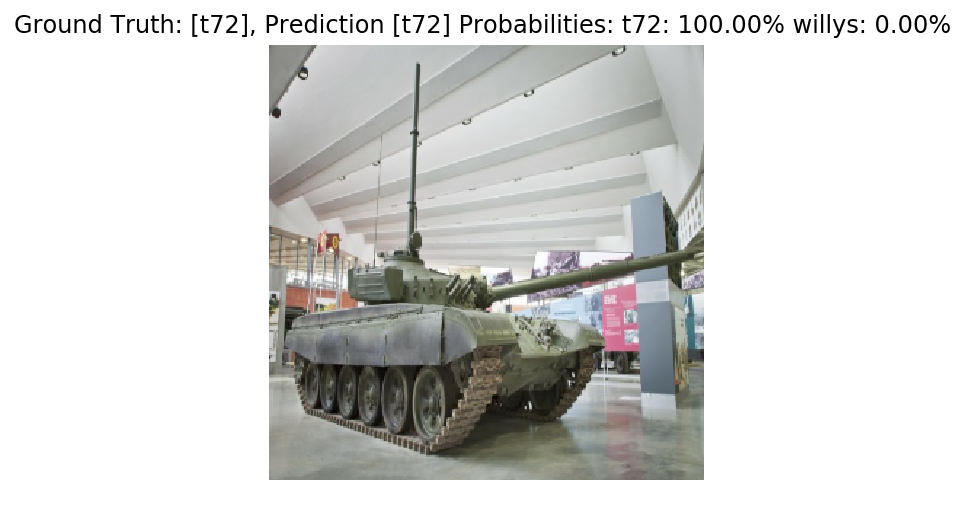

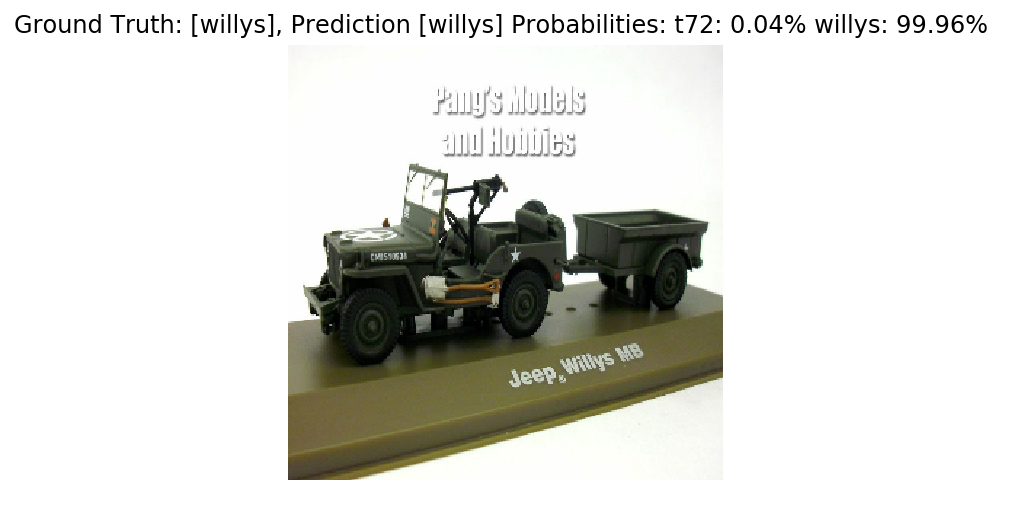

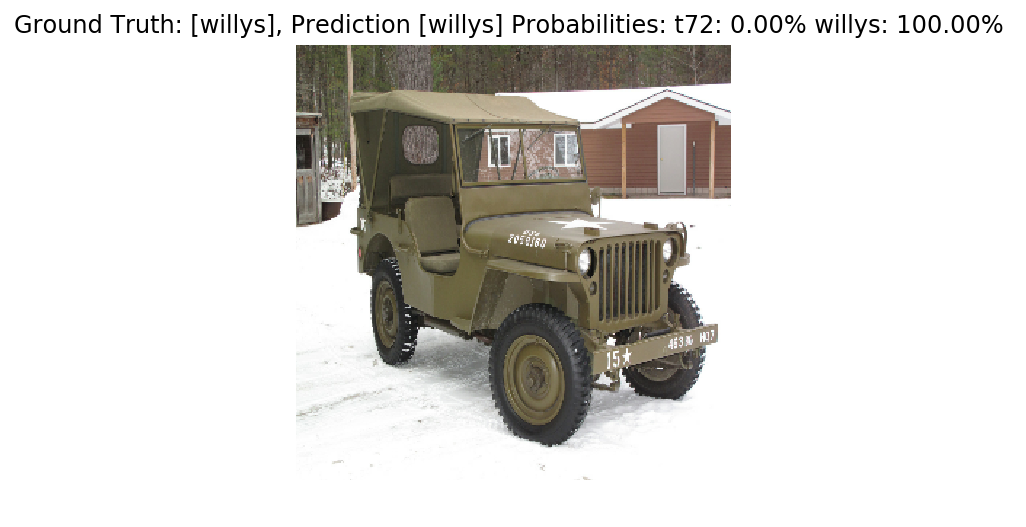

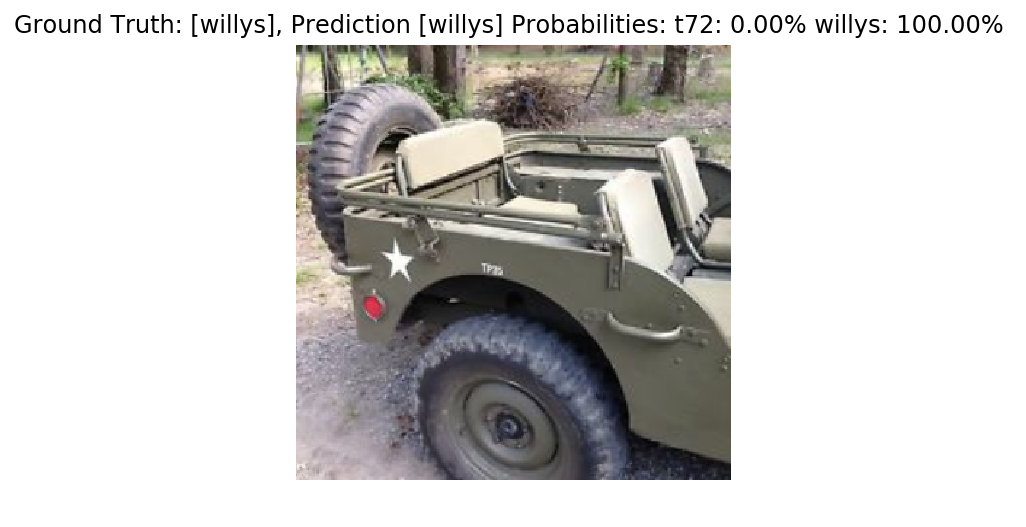

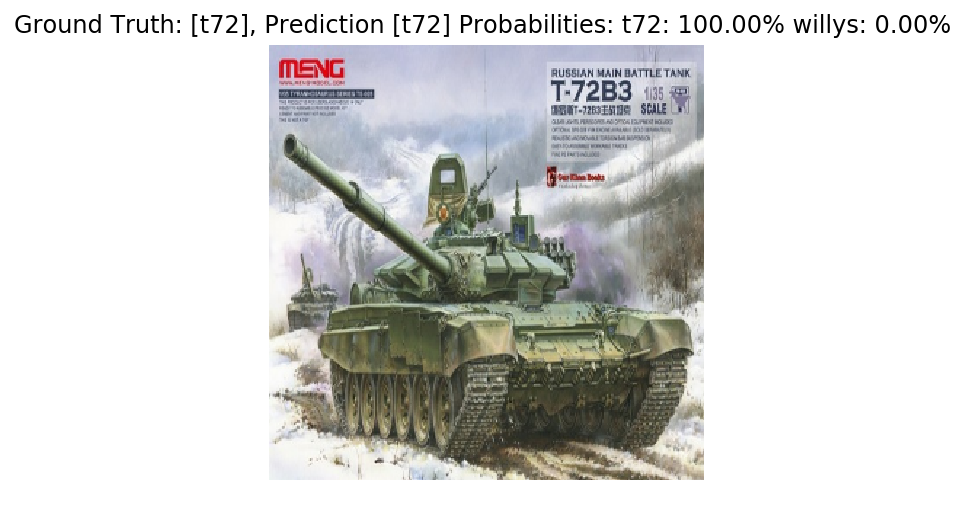

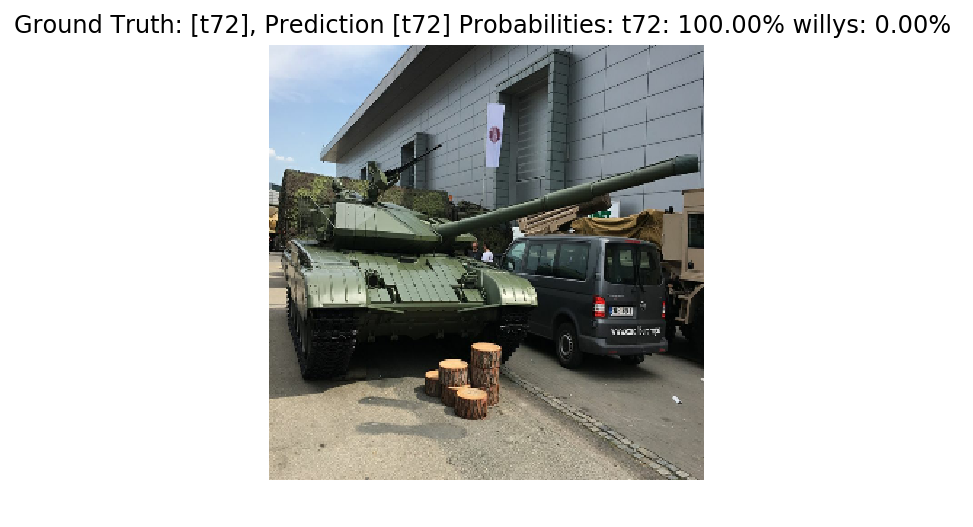

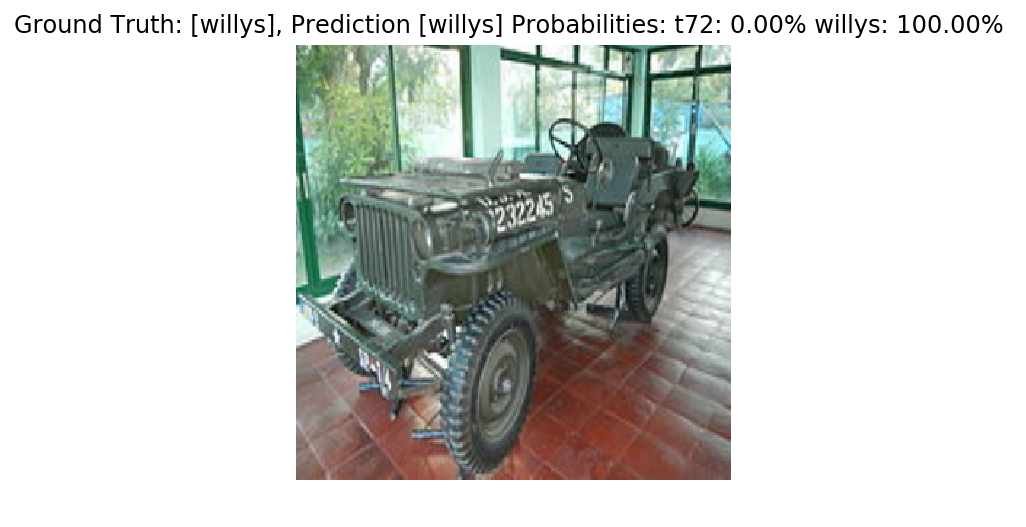

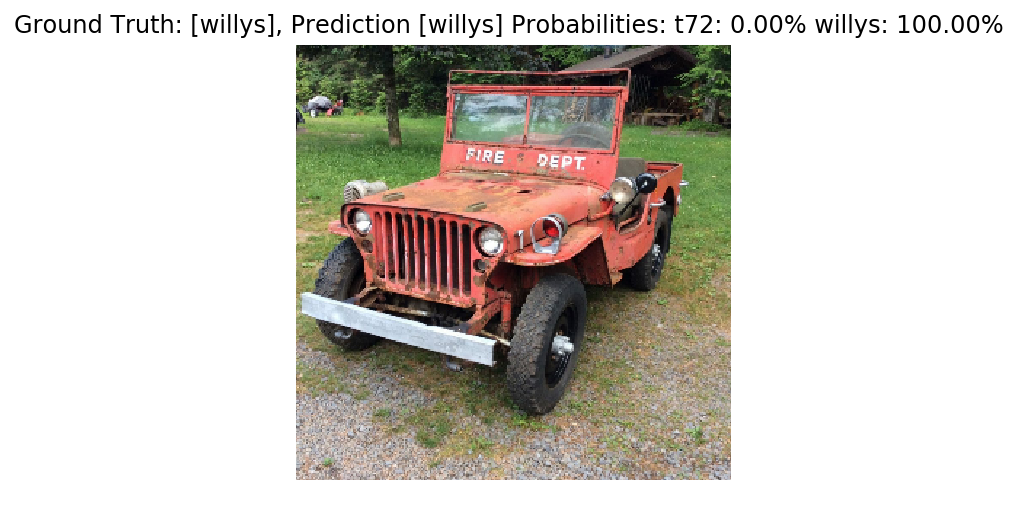

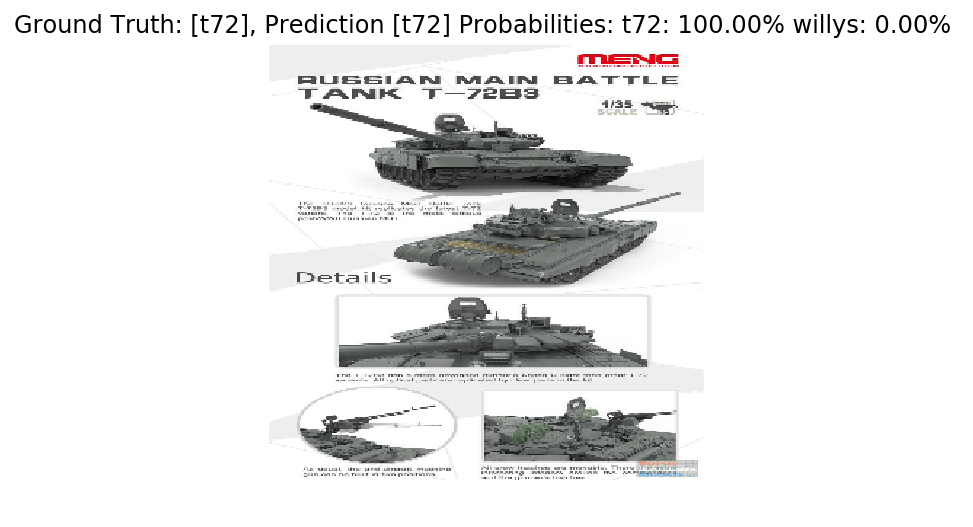

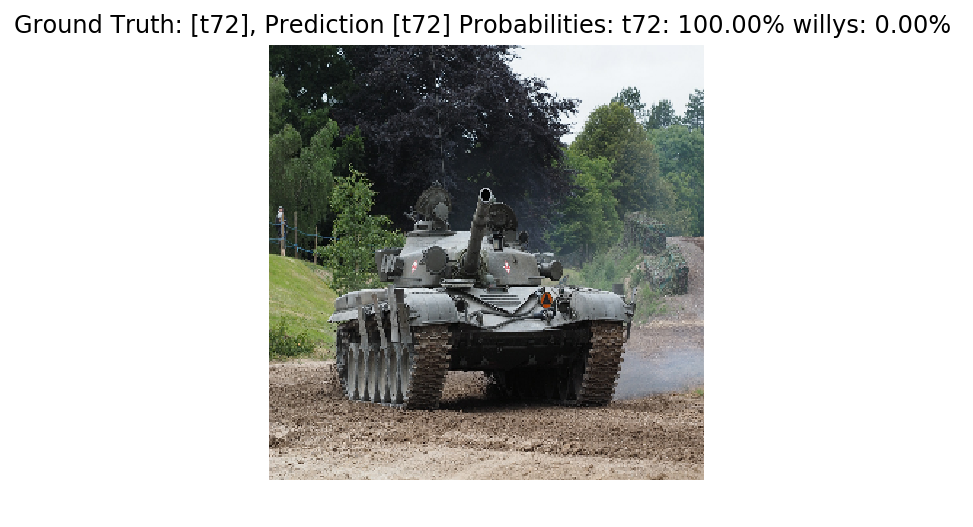

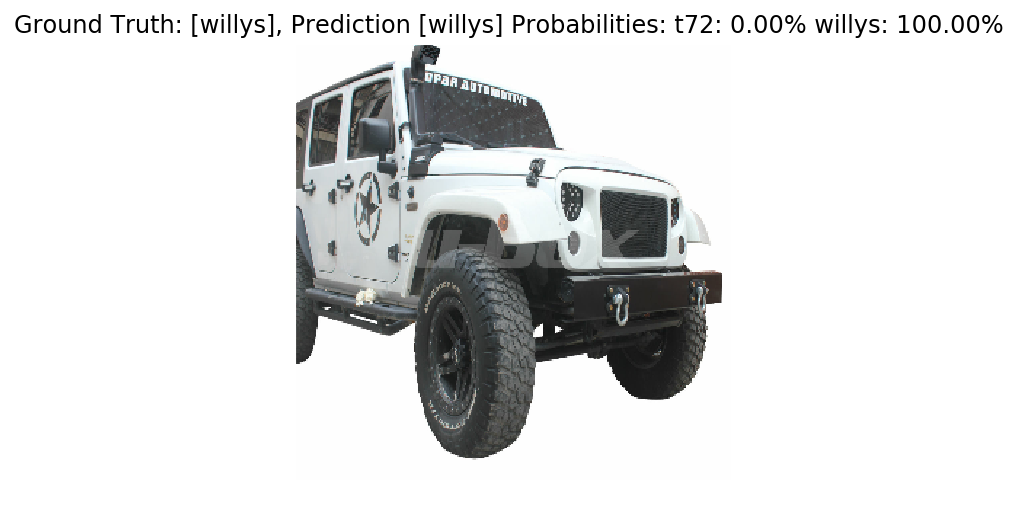

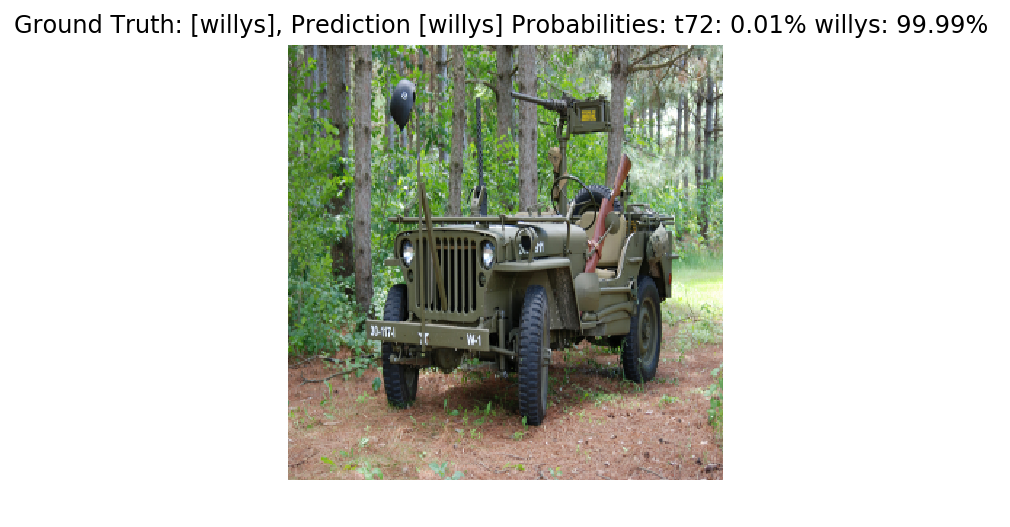

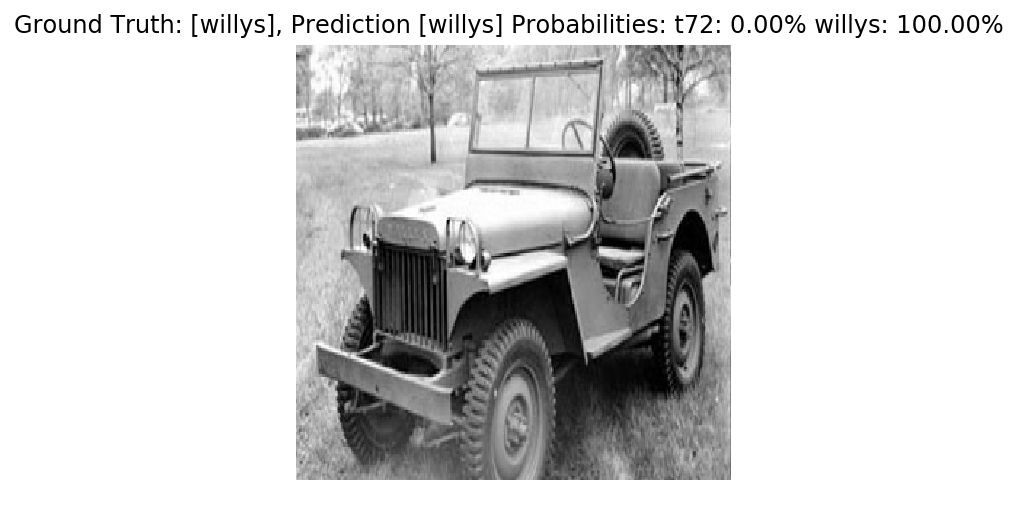

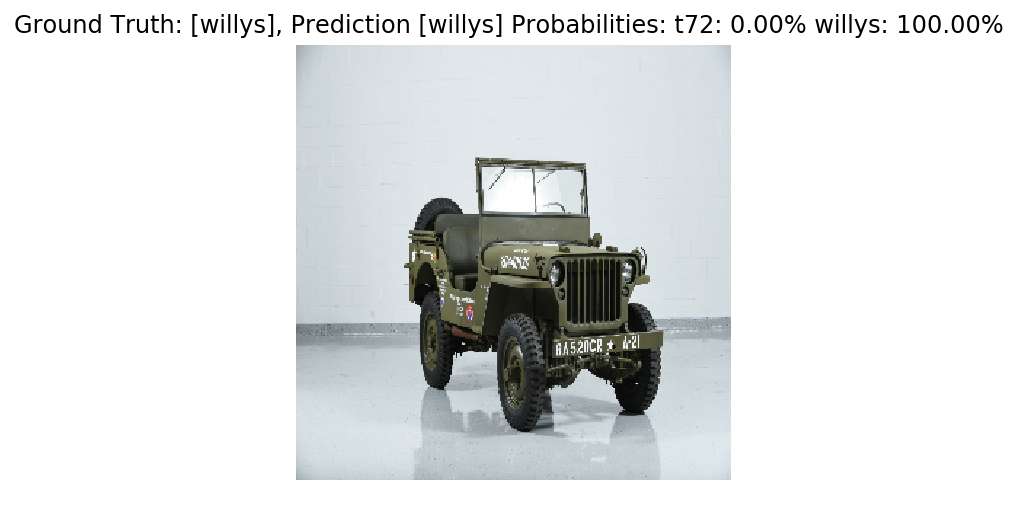

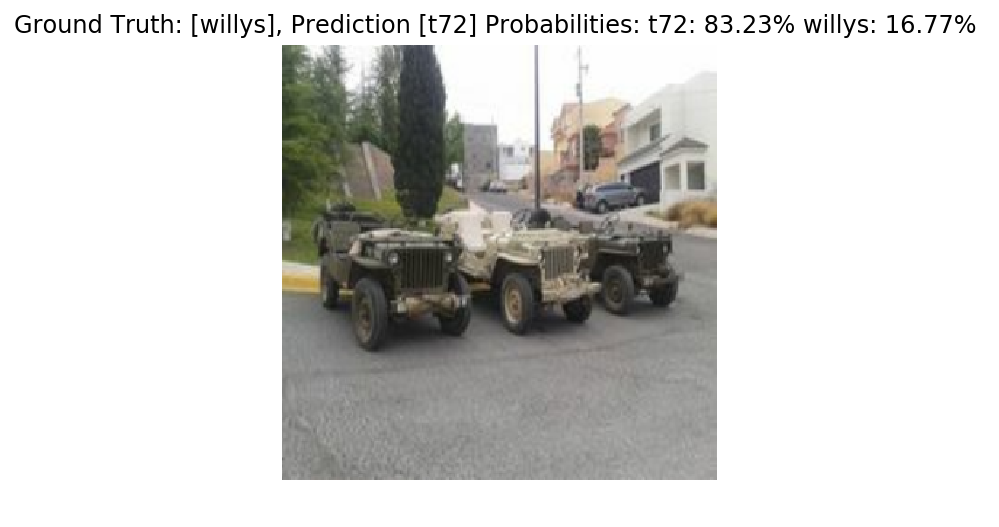

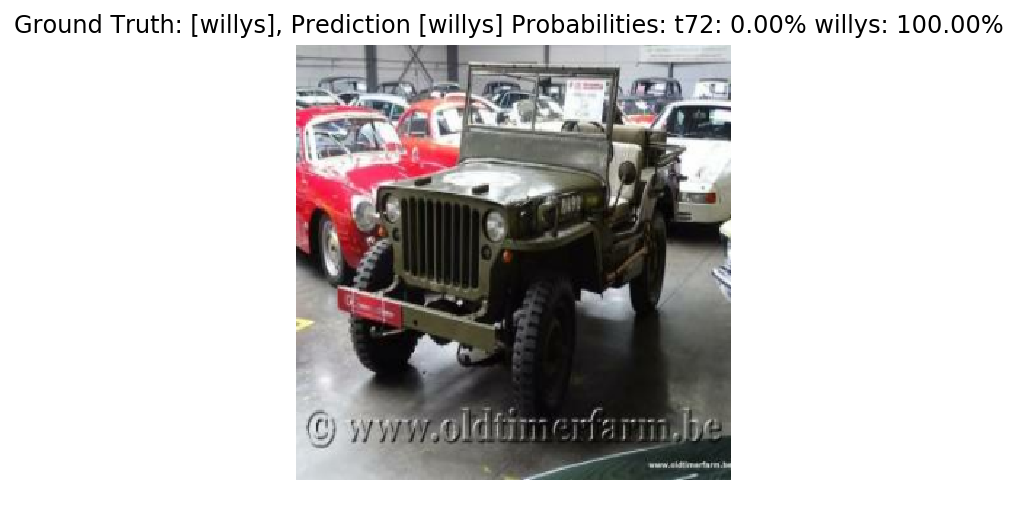

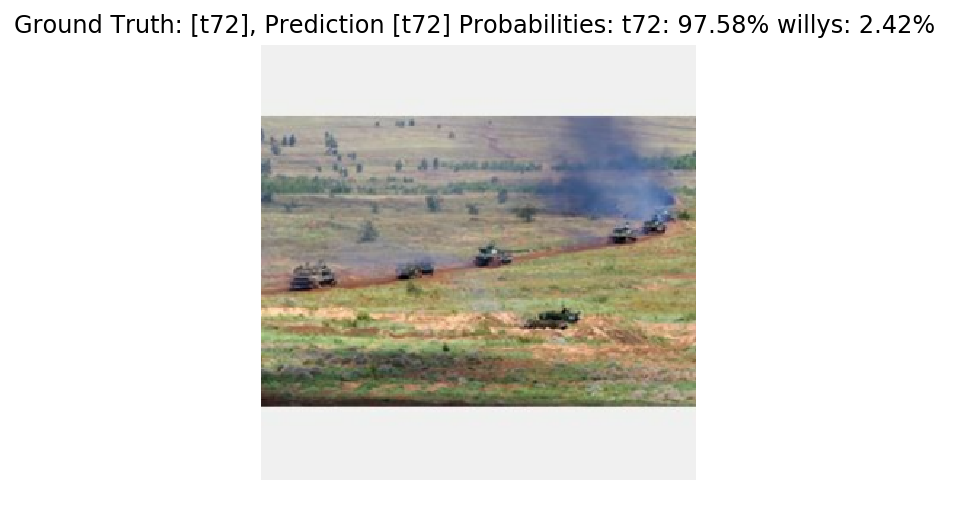

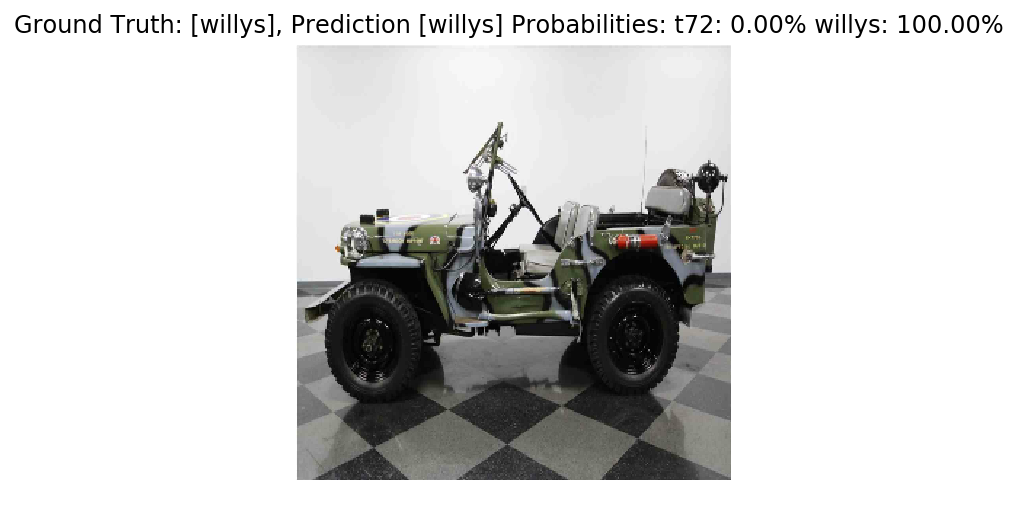

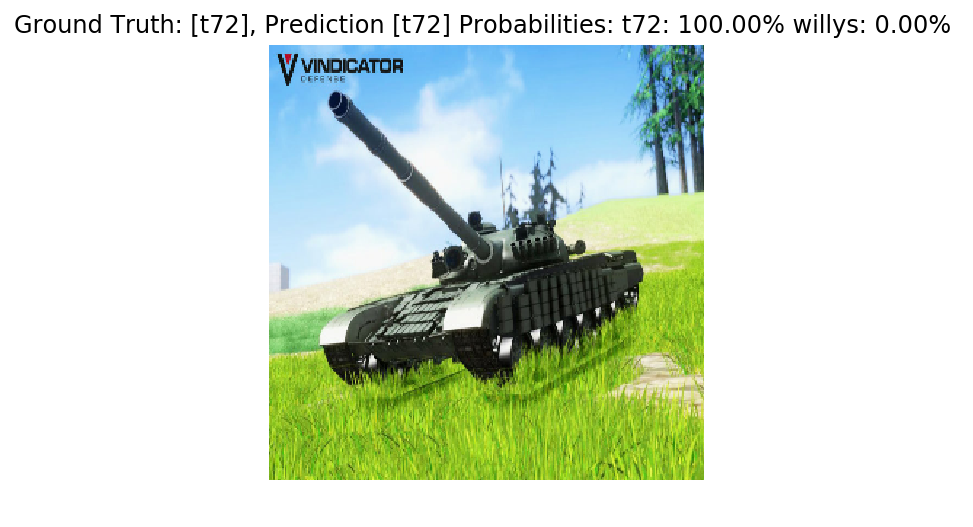

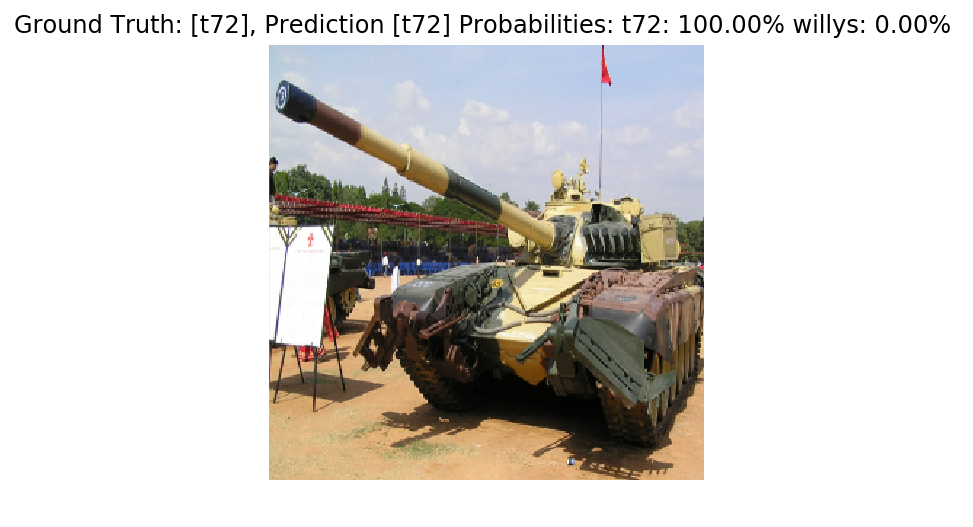

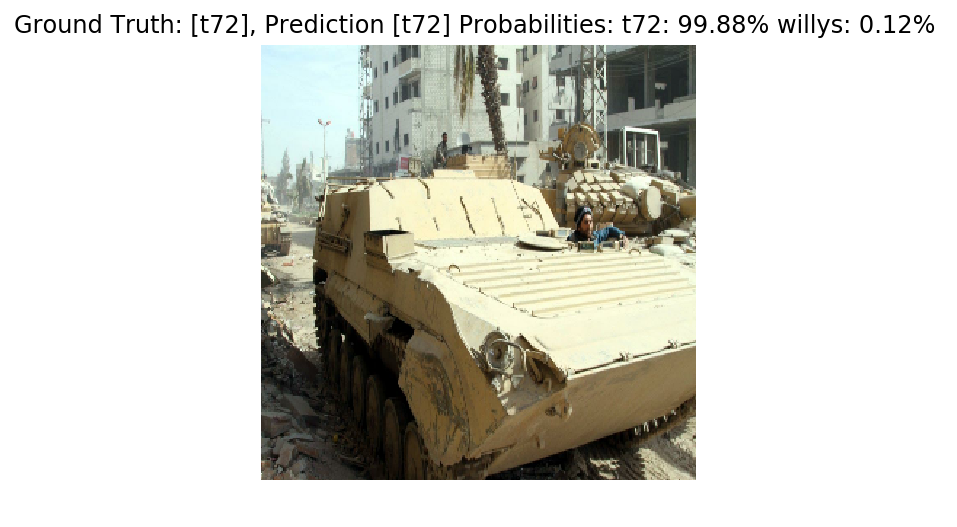

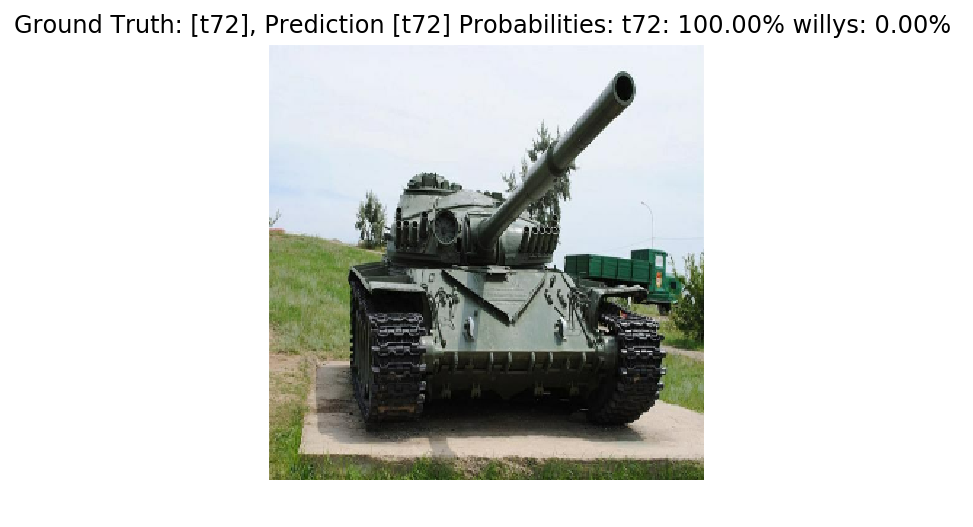

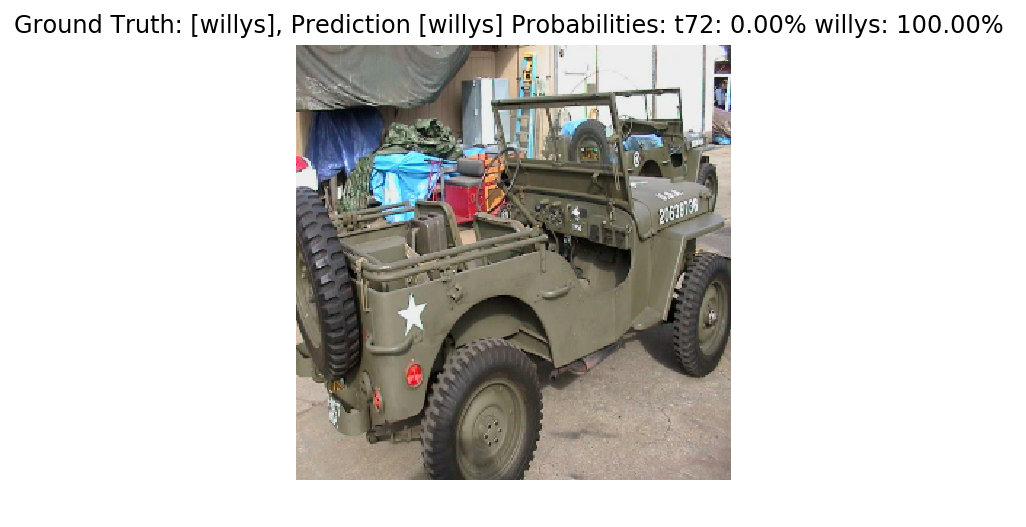

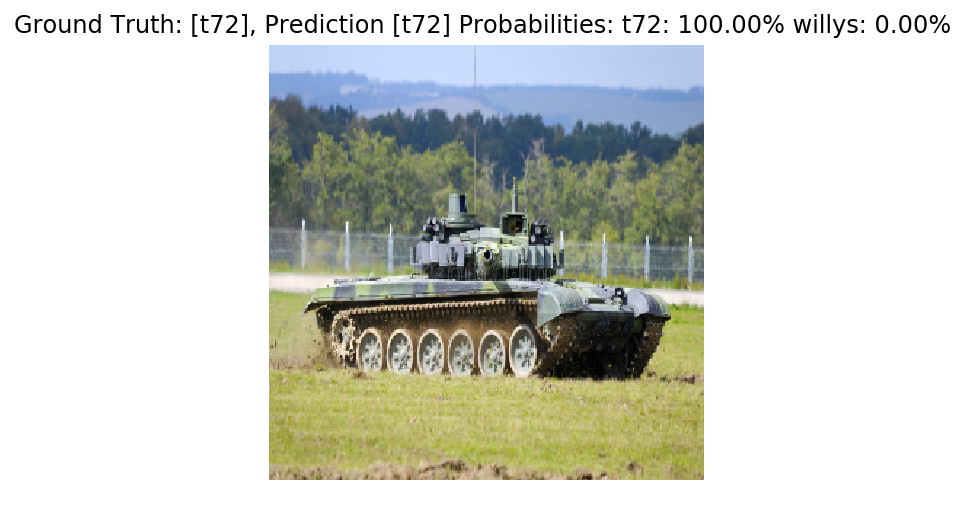

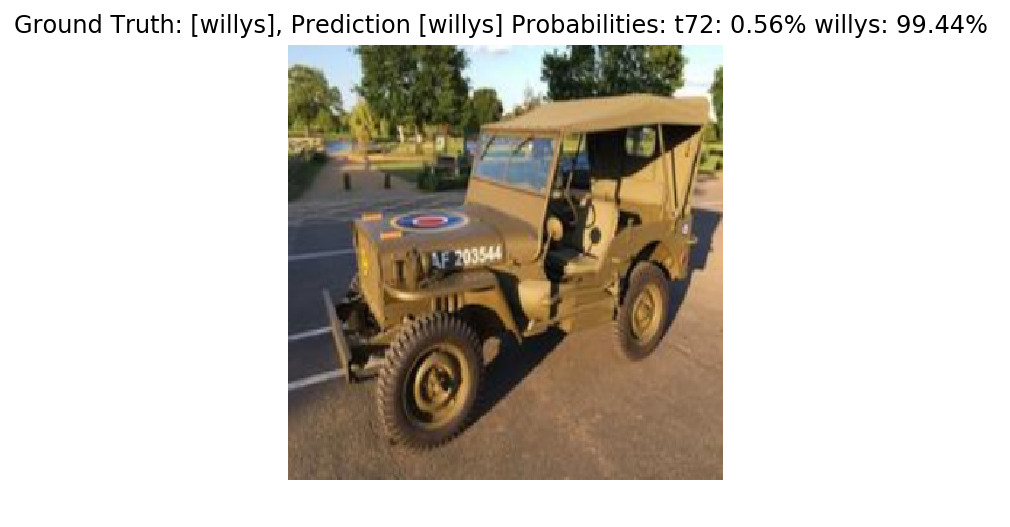

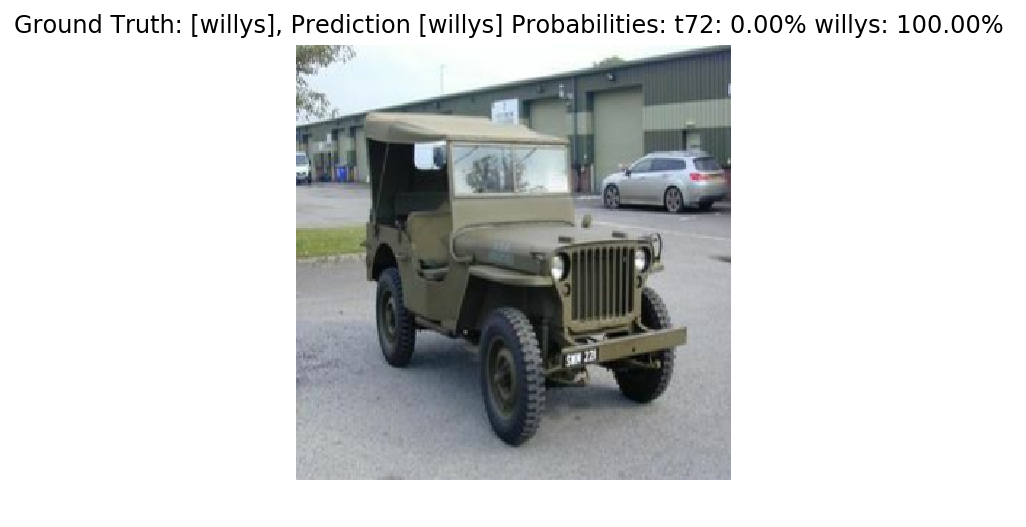

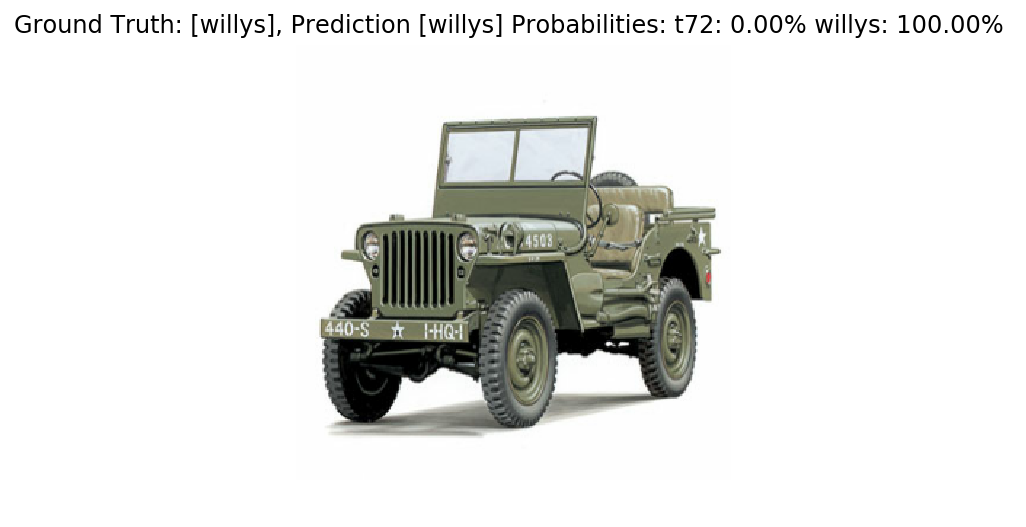

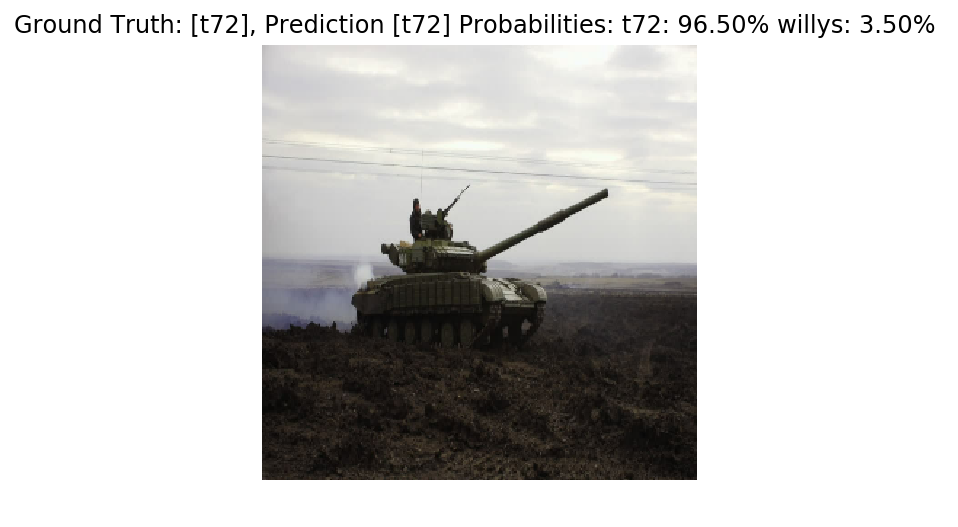

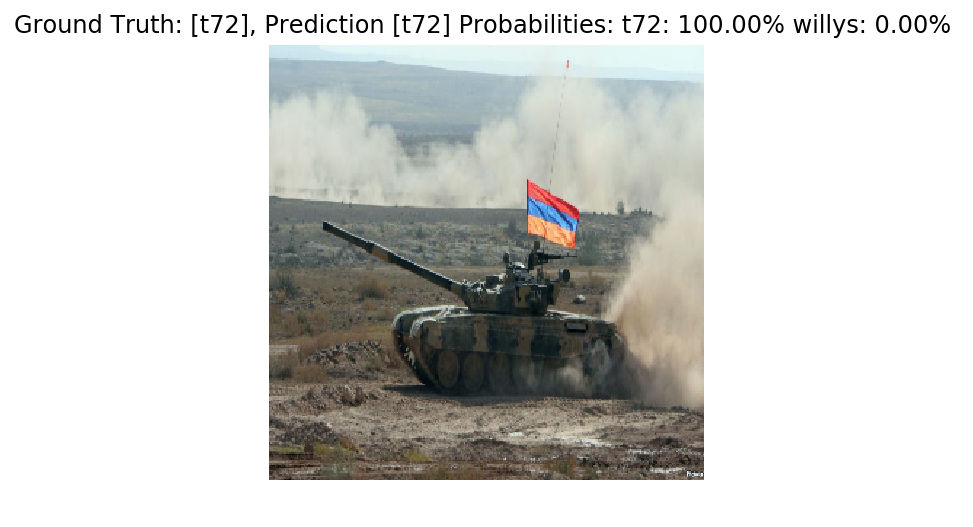

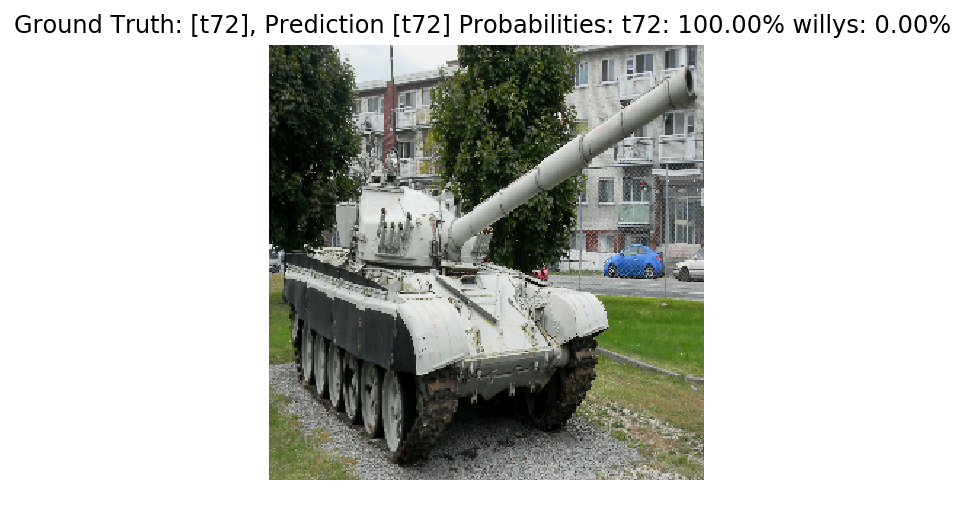

(30, 2)
(30, 2)
(30, 2)
(30, 2)
(30, 2)
(30, 2)
(30, 2)
(30, 2)
(30, 2)
(30, 2)
(30, 2)
(30, 2)
(30, 2)
(30, 2)
Overall accuracy 0.975


In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

BATCH_SIZE = 30
TEST_SAMPLE_SIZE = 500

all_batch_stats = []

def getProbsAsStr(probabilities):
    CLASS_NAMES=['t72','willys']
    probs_str = 'Probabilities: '
    for label, prob in zip(CLASS_NAMES, probabilities):
        probs_str += '%s: %.2f%% ' % (label, prob*100)
    return probs_str

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    test_dataset = get_dataset('/root/qq/t72_willys', TRAIN_SAMPLES, 'validation')
    images, images_raw, labels = load_batch(
        test_dataset, BATCH_SIZE, INCEPTION_IMAGE_SIZE, INCEPTION_IMAGE_SIZE)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception_v3_concat.inception_v3_concat_arg_scope()):
        logits, _ = inception_v3_concat.inception_v3_concat(images, num_classes=test_dataset.num_classes, is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(TRAINED_MODEL_DIR)
    init_fn = slim.assign_from_checkpoint_fn(checkpoint_path, slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            all_accuracy = []
            
            for i in range(int(TEST_SAMPLE_SIZE/BATCH_SIZE)):
                np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
                print (np_probabilities.shape)
                all_batch_stats.append((np_labels, np_probabilities))
                if i == 1: # show images 
                    for j in range(BATCH_SIZE): 
                        image = np_images_raw[j, :, :, :]
                        true_label = np_labels[j]
                        predicted_label = np.argmax(np_probabilities[j, :])
                        predicted_name = test_dataset.labels_to_names[predicted_label]
                        true_name = test_dataset.labels_to_names[true_label]
                        plt.figure()
                        plt.imshow(image.astype(np.uint8))
                        plt.title('Ground Truth: [%s], Prediction [%s] '
                                  % (true_name, predicted_name) + getProbsAsStr(np_probabilities[j, :]))
                        plt.axis('off')
                        plt.show()

# Calculate accuracy over the whole test set
all_batch_accuracy = []
for labels, probs in all_batch_stats:
    for label, prob in zip(labels, probs):
            all_batch_accuracy.append(np.argmax(prob) == label)
print('Overall accuracy', np.mean(all_batch_accuracy))